In [1]:
# Import modules needed for the run
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import accuracy_score
from pyts.metrics import dtw
from pyts.classification import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Load train and test data
train_data = np.genfromtxt('../data/OSULeaf_TRAIN.txt')
test_data = np.genfromtxt('../data/OSULeaf_TEST.txt')

# Split the data and the labels
X_train = train_data[:,1:]
y_train = train_data[:,0]
X_test = test_data[:,1:]
y_test = test_data[:,0]

#Defining the classes used in the data set
classes = np.unique(y_train)

## Motivation
The outline of a leaf is one of its most distinctive and consistent features, often more informative than color or texture, especially for species identification. Leaf margins — whether they are serrated, lobed, smooth, or compound — carry key taxonomic information. While computer vision techniques do exist that can analyze the outline of images using edge detection, we can also parametrize the outline to turn it into a 1D signal. This is typically done by tracing the contour of the leaf and measuring properties such as the radial distance from the centroid or curvature at each point along the edge. The result is a 1D signal that preserves the overall shape and fine structural features of the leaf margin. This work takes the 1D signal from already processed outlines from @gandhi2002content and checks two classification methods: K-Nearest Neighbor Classifier using Dynamic Time Warping as a distance metric, and Shapelet Transform Classifier.

![Sample of each class of leaf to identify](class_samples.png)

![Sample of leaf outline turning into a 1D time series](leaf_outline.webp)

## Dynamic Time Warping (DTW)
Dynamic Time Warping (DTW) is a flexible distance metric that compares sequences while allowing for non-linear time shifts [#dtwreference]. Unlike Euclidean distance, which requires sequences to be aligned, DTW warps the time axis to find the best match — ideal for comparing our 1D leaf outlines as the closed shape naturally results in a cyclical signal. This means that we do not have to align each leaf when taking the outline as the algorithm will align the signals to minimize distance. We use a K-Nearest Neigbors (KNN) classifier which measures the distance between our test data and their k-nearest neighbors to see which class the most neighbors fall into.

![Example of Dynamic Time Warping performed on ECG signals. Source: https://minimizeregret.com/note/2023/12/12/stop-using-dtw/](dtw_example_ecg-1.png)

In [2]:
n_neigh = np.arange(1,11)
n_accuracy = []
for n in n_neigh:
    dtw_clf = KNeighborsClassifier(n_neighbors=n, metric = 'dtw')
    dtw_clf.fit(X_train, y_train)
    with warnings.catch_warnings(): #FutureWarning ignore
        warnings.simplefilter('ignore')
        dtw_pred = dtw_clf.predict(X_test)
    n_accuracy.append(accuracy_score(y_test, dtw_pred))

For this method we need to tune a hyper-parameter for this classifier which is the kth nearest neighbor to consider. We can see from the plot that the accuracy actually goes down as we increase k which is due to the fact that DTW uses the whole signal when comparing sequences. This means that any noise present within the signal has the same significance as the actual signal which makes the method sensitive to noise. 

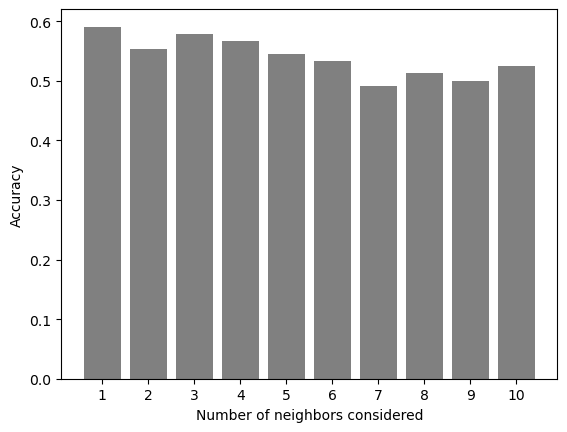

In [3]:
#| label: fig-ktune
#| fig-cap: "Bar plot of accuracy as the number of neighbors considered increases."

plt.bar(n_neigh,n_accuracy, color = 'gray');
plt.xticks(n_neigh);
plt.xlabel("Number of neighbors considered");
plt.ylabel("Accuracy");

## Shapelets Classification
Shapelets work by identifying subsequences within time series that are most informative for distinguishing between classes. Rather than comparing entire leaf outlines directly, the algorithm learns a set of shapelets that frequently occur in one class and not others. During classification, each new time series (leaf outline) is compared to the learned shapelets, and distances to these shapelets are used as input features for a standard classifier.

In [4]:
s_class = np.arange(1,11)
s_accuracy = []
for n in s_class:
    clf = ShapeletTransformClassifier(estimator=RandomForestClassifier(), 
                                  n_shapelet_samples=1000,
                                  max_shapelets=len(classes)*n,
                                  max_shapelet_length=20,
                                  batch_size=50)
    clf.fit(X_train, y_train)
    shp_pred = clf.predict(X_test)
    s_accuracy.append(accuracy_score(y_test, shp_pred))

The hyperparameter to optimize here is the number of shapelets per class which can be interpreted in the terms of PCA as the number of features you need to extract from the data to define a class archetype. As seen in the figure below, the accuracy of the shapelets method increases as we increase the number of shapelets per class. While setting the maximum shapelets per class to be as high as possible would seem to also maximize the accuracy, we also observe from the figure that the increase in accuracy slows down after 3 shapelets per class. This means that we only require 3 features per class to classify our test data which are subsequences 20 timesteps long. This points to the advantage of shapelets over DTW in that we can identify the most significant subsequences for classification instead of having to take the entire subsequence everytime. This saves on computation as when running the code, the DTW classifier runs significantly longer than the shapelets classifier. 

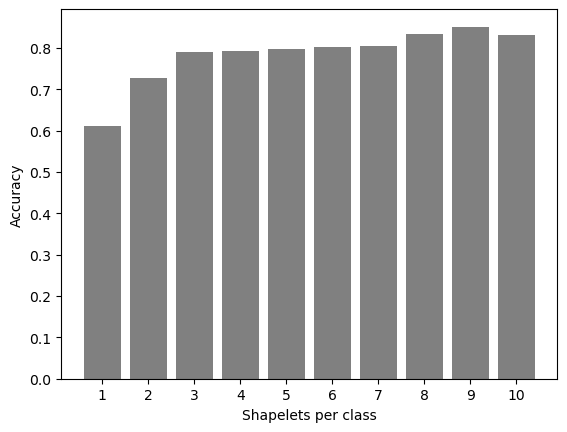

In [5]:
#| label: fig-stune
#| fig-cap: "Bar plot of accuracy as the number of shapelets pre class increases."

plt.bar(s_class,s_accuracy, color = 'gray');
plt.xticks(s_class);
plt.xlabel("Shapelets per class");
plt.ylabel("Accuracy");

## Comparison of the two classifiers

In [7]:
dtw_clf = KNeighborsClassifier(n_neighbors=3, metric = 'dtw')
dtw_clf.fit(X_train, y_train)
with warnings.catch_warnings(): #FutureWarning ignore
    warnings.simplefilter('ignore')
    dtw_pred = dtw_clf.predict(X_test)

shp_clf = ShapeletTransformClassifier(estimator=RandomForestClassifier(), 
                                  n_shapelet_samples=1000,
                                  max_shapelets=len(classes)*9,
                                  max_shapelet_length=20,
                                  batch_size=50)
shp_clf.fit(X_train, y_train)
shp_pred = shp_clf.predict(X_test)

To compare the two classifiers, we first look at their confusion matrix which is a matrix that tells us how many predicted labels match the true labels for each class. From our results, we can already see that the shapelets transform method has higher accuracy with fewer wrong predictions compared to the DTW method that makes more frequent errors in classifying the different leaves. It should be noted that both methods struggle in identifying leaves belonging to class 6 which is the California Black Oak. This could be due to the outline of the leaves sharing many similar features with the other plant species.

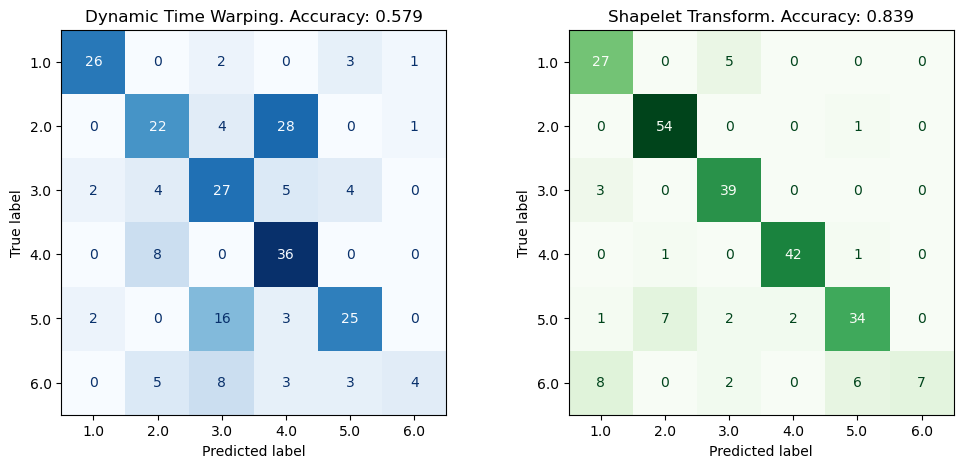

In [8]:
#| label: fig-cm
#| fig-cap: "Confusion matrix of the two different classification methods."

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

dtw_acc = accuracy_score(y_test, dtw_pred)
shp_acc = accuracy_score(y_test, shp_pred)

dtw_cm = confusion_matrix(y_test, dtw_pred, labels = classes)
shp_cm = confusion_matrix(y_test, shp_pred, labels = classes)

dtw_cm_display = ConfusionMatrixDisplay(dtw_cm, display_labels = classes).plot(ax=axes[0], cmap='Blues', colorbar=False)
shp_cm_display = ConfusionMatrixDisplay(shp_cm, display_labels = classes).plot(ax=axes[1], cmap='Greens', colorbar=False)

axes[0].set_title(f"Dynamic Time Warping. Accuracy: {dtw_acc:.3f}");
axes[1].set_title(f"Shapelet Transform. Accuracy: {shp_acc:.3f}");

Another comparison to make is to check how resilient the methods or when the signal is tampered or corrupted. In this work, we simulate corrupting the signal by randomly setting a portion of the signal to zero which simulates a signal interupption. We increase this portion from 0 to 1 in order to observe how quickly the accuracy of each method decreases as more of the signal is removed.

In [9]:
def corrupt_data(X, corruption_ratio):
    X_corrupted = X.copy()
    n_samples, ts_length = X.shape
    n_total = n_samples * ts_length
    n_corrupt = int(n_total * corruption_ratio)
    indices = np.random.choice(n_total, size=n_corrupt, replace=False)
    for idx in indices:
        i, j = divmod(idx, ts_length)
        X_corrupted[i, j] = 0
    return X_corrupted

In [12]:
shp_accuracy = []
dtw_accuracy = []
corruption_ratios = np.linspace(0,1,10)
for ratio in corruption_ratios:
    X_corrupted = corrupt_data(X_test, corruption_ratio=ratio)
    s_pred = shp_clf.predict(X_corrupted)
    with warnings.catch_warnings(): #FutureWarning ignore
        warnings.simplefilter('ignore')
        d_pred = dtw_clf.predict(X_corrupted)
    dtw_accuracy.append(accuracy_score(y_test,d_pred))
    shp_accuracy.append(accuracy_score(y_test, s_pred))

Looking at the plots, we notice that the Shapelet Transform method falls off sharply as the proportion of data corrupted increases while the decrease in accuracy for DTW is slower. This is because our method for corrupting the signal amounts to removing portions of the signal which affects each method differently. For the shapelets method, removing portions of the signal is tantamount to removing features from the signal which could be significant in differentiating between different classes. On the other hand, the DTW method does not differentiate between signal and noise and so the removal of parts of the raw signal is likely to remove equal amounts of true signal and noise which would not affect the distance measured using DTW much. This eventually decreases the accuracy as at the limit of the entire signal being removed, the classification becomes a measure of amplitude which is equal for all test data and is tantamount to a random selection.

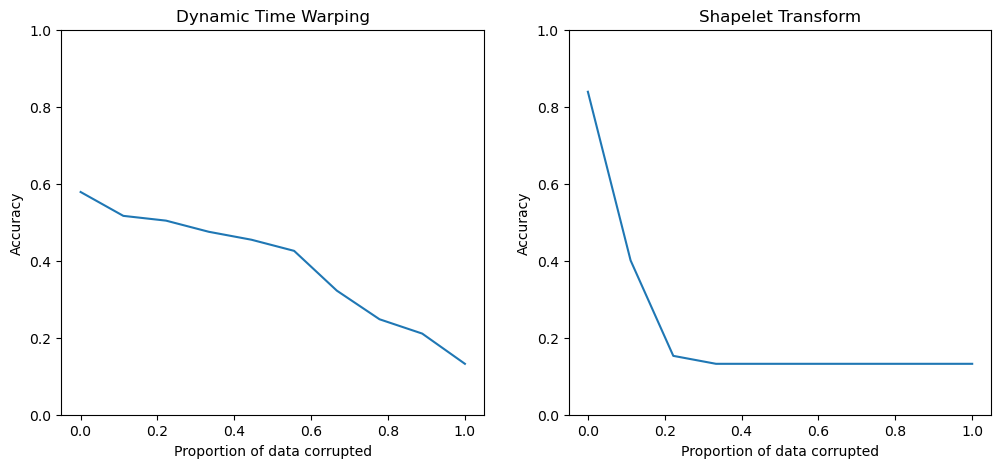

In [13]:
#| label: fig-noise
#| fig-cap: "Plot of accuracy vs proportion of data corrupted for the two methods."

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(corruption_ratios, dtw_accuracy)
axes[0].set_xlabel("Proportion of data corrupted")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0,1)
axes[0].set_title("Dynamic Time Warping");

axes[1].plot(corruption_ratios, shp_accuracy)
axes[1].set_xlabel("Proportion of data corrupted")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0,1)
axes[1].set_title("Shapelet Transform");

## Conclusion

We show how we can take the outlines of leaves parametrized into a 1D time series, and apply time series classification methods to them to classify the leaves by species. We compare two different methods of time series classification, namely Dynamic Time Warping and Shapelets Transform based on their accuracy and their resilience to missing data points. We learned that while the shapelets method is more accurate in classifying leaves, it is more vulnerable to missing data points which could occur due to measurement error compared to the DTW method that is more robust but is far more inaccurate in classifying leaves. Further work in this could focus on applying this method to other classification exercises that place more significance to the shape of objects compared to any other feature.

## References